In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import scipy.linalg as sl
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
from itertools import product

In [2]:
def SMA(series, date, n=30):
    n = min(len(series[:date]), n)
    t = series.index.get_loc(date)
    s = series[t-n-1:t+1].sum() / n
    return s

def EMA(series, date, a=2/3, n=30):
    n = min(len(series[:date]), n)
    s = 0
    t = series.index.get_loc(date)
    for i in range(n):
        s += a**i * series[t-i]
    s *= (1 - a) / (1 - a**n)
    return s

In [3]:
class volatility_smile:
    
    def __init__(self, values, grid=500, step=1000):
        
        if len(values) < grid * 100 / step:
            print('ERROR: Not enough values!')
        if len(values) > grid * 100 / step:
            print('ERROR: Too much values!')
            
        ind = np.arange(len(values)) * step
        
        self.curve = pd.Series(values, index=ind)
        self.grid = grid
        self.step = step
        
    def interpolate(self, strike):
        
        if strike < self.curve.index[0]:
            print('ERROR: strike is less than first index!')
        if strike > self.curve.index[-1]:
            print('ERROR: strike is bigger than last index!')
        
        i = 0
        
        while self.curve.index[i] <= strike:
            i += 1
        
        fx = self.curve.values[i-1]
        fy = self.curve.values[i]
        
        return ((strike - self.curve.index[i-1]) * fy + (self.curve.index[i] - strike) * fx) / self.step
    
    def plot(self, x=15, y=6):
        
        self.curve.plot(figsize=(x,y), style='-o')

class option:
    
    
    def __init__(self, typ, strike, maturity, premium, grid=500, smile='None'):
        
        self.typ = typ
        self.strike = strike
        self.maturity = pd.to_datetime(maturity)
        self.premium = premium
        price = np.array(range(grid)) * 100
        res = pd.Series(np.zeros(grid)-premium, price)
        if typ == 'call':
            for i in range(grid):
                if i*100 > strike:
                    res[i*100] += i*100 - strike
        if typ == 'put':
            for i in range(grid):
                if i*100 < strike:
                    res[i*100] += strike - i*100
        self.pnl = res
        self.smile = smile
    
    
    def value(self, spot, date, rate, vol=0, greeks=True):
        
        date = pd.to_datetime(date)
        
        if date > self.maturity:
            self.price = 0
            return
        
        if self.smile != 'None':
            vol = self.smile.interpolate(spot)
        
        T = (self.maturity.timestamp() - date.timestamp()) / 3600 / 24 / 365
        
        if T*vol*self.strike != 0:
            d1 = (np.log(spot / self.strike) + (rate + vol ** 2 / 2) * T) / vol / np.sqrt(T)
        else:
            d1 = np.inf
        d2 = d1 - vol * np.sqrt(T)
        
        if self.typ == 'call':
            self.price = ss.norm.cdf(d1) * spot - ss.norm.cdf(d2) * self.strike * np.exp(-rate*T)
            if greeks:
                self.delta = ss.norm.cdf(d1)
                self.gamma = ss.norm.pdf(d1) / spot / vol / np.sqrt(T)
                self.theta = -ss.norm.pdf(d1) * spot * vol / np.sqrt(T) / 2 - rate * self.strike * np.exp(-rate*T) * ss.norm.cdf(d2)
        
        else:
            self.price = ss.norm.cdf(-d2) * self.strike * np.exp(-rate*T) - ss.norm.cdf(-d1) * spot
            if greeks:
                self.delta = ss.norm.cdf(d1) - 1
                self.gamma = ss.norm.pdf(d1) / spot / vol / np.sqrt(T)
                self.theta = -ss.norm.pdf(d1) * spot * vol / np.sqrt(T) / 2 + rate * self.strike * np.exp(-rate*T) * ss.norm.cdf(-d2)
            
    def plot(self, date, rate, vol=0, grid=500):
        price = np.array(range(grid)) * 100
        res = pd.Series(np.zeros(grid)-self.premium, price)
        if pd.to_datetime(date) <= self.maturity:
            res[0] = self.pnl[0]
        else:
            res[0] = -self.premium
        for spot in res.index[1:]:
            self.value(spot, date, rate, vol, greeks=False)
            res[spot] += self.price
        return res
            
class portfolio:
    
    def __init__(self, options, curves):
        
        self.options = options
        self.curves = curves
        
    def add(self, options):
        
        self.options += options

In [4]:
call = option('call', 26000, '2022-12-30 11:00:00', 3220)
put = option('put', 26000, '2022-12-30 11:00:00', 5780)

In [5]:
date = '2022-08-06 16:30:00'

call.value(23212, date, 0.0235, 0.715)
put.value(23212, date, 0.0235, 0.715)

print(call.price, put.price)

3217.245429614706 5762.370551263986


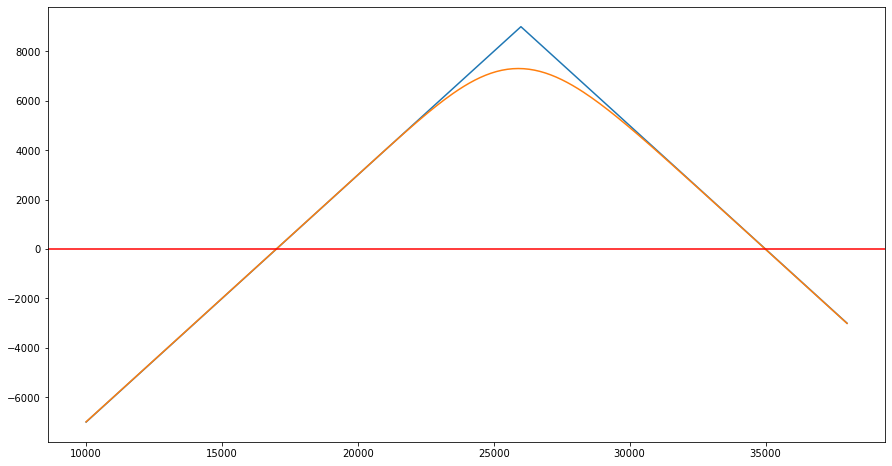

In [8]:
date = '2022-12-25 16:30:00'

cl = call.plot(date, 0.0235, 0.715)
pt = put.plot(date, 0.0235, 0.715)

struct = -cl-pt

plt = (-call.pnl-put.pnl)[100:381].plot(figsize=(15,8))
(-cl-pt)[100:381].plot(figsize=(15,8))

plt.axhline(0, color = 'red')

2376.1232051350344 0


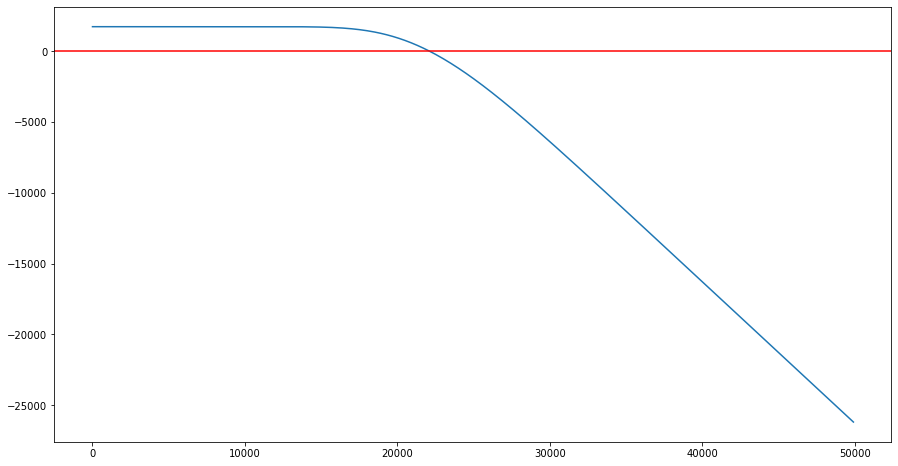

In [10]:
dec = option('call', 22000, '2022-12-30 11:00:00', 4860)
sept = option('call', 22000, '2022-09-30 11:00:00', 3120)

date = '2022-12-06 10:59:59'
vol1 = 0.740
vol2 = 0.705

dec.value(23180, date, 0.0175, vol1)
sept.value(23180, date, 0.0175, vol2)

print(dec.price, sept.price)

cl = dec.plot(date, 0.0175, vol1)
pt = sept.plot(date, 0.0175, vol2)

plt = (-cl+pt).plot(figsize=(15,8))

plt.axhline(0, color = 'red')

In [16]:
smile_144d = volatility_smile([1.8700, 1.2106, 0.9218, 0.8211, 0.7519,
                               0.7227, 0.7166, 0.7210, 0.7341, 0.7503,
                               0.7638, 0.7803, 0.7936, 0.8076, 0.8227,
                               0.8663, 0.8390, 0.8612, 0.9027, 0.9562],
                              grid=500, step=1000)

smile_144d = volatility_smile([1.8700, 1.2106, 0.9218, 0.8211, 0.7519,
                               0.7227, 0.7166, 0.7210, 0.7341, 0.7503,
                               0.7638, 0.7803, 0.7936, 0.8076, 0.8227,
                               0.8663, 0.8390, 0.8612, 0.9027, 0.9562],
                              grid=1000, step=5000)

ERROR: Not enough values!


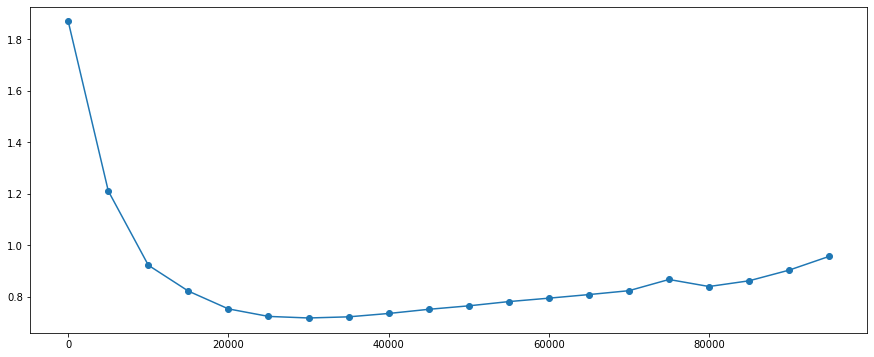

In [17]:
smile_144d.plot()

In [18]:
call = option('call', 23000, '2022-12-30 11:00:00', 4380, smile=smile_144d)
put = option('put', 23000, '2022-12-30 11:00:00', 4020, smile=smile_144d)

hedge1 = option('call', 23000, '2022-08-12 11:00:00', 810)
hedge2 = option('put', 23000, '2022-08-12 11:00:00', 1000)

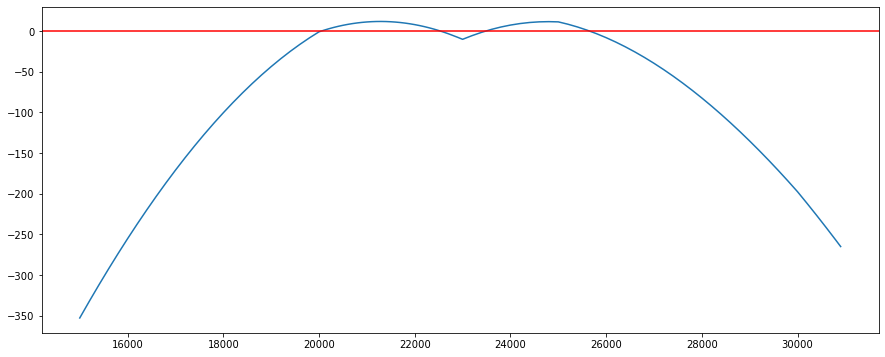

In [24]:
date = '2022-08-12 10:59:59'

#struct = -0.2 * (call.plot(date, 0.0175) + put.plot(date, 0.0175))[150:310]
struct = -0.2 * (call.plot(date, 0.0175) + put.plot(date, 0.0175) - 0.25*hedge1.plot(date, 0.175, vol=0.9))[150:310]
#struct = -0.2 * (call.plot(date, 0.0175) + put.plot(date, 0.0175) - hedge1.plot(date, 0.175, vol=0.9)  - hedge2.plot(date, 0.175, vol=0.9))[100:360]

plt = struct.plot(figsize=(15,6))
plt.axhline(0, color = 'red')

In [25]:
short_call1 = option('call', 23000, '2022-08-09 11:00:00', 460)
short_call2 = option('call', 23500, '2022-08-09 11:00:00', 220)
long_call   = option('call', 21000, '2022-08-19 11:00:00', 2600)

delta = [0.6347,0.3950,0.8084]
gamma = [0.0045,0.0047,0.00009]
theta = [-98.64,-100.27,0]

A = np.array([delta,gamma,theta])
b = np.array([0,0,100])

w = sl.solve(A,b)
print(w)

[-30.75213638  29.25491905   9.8499356 ]


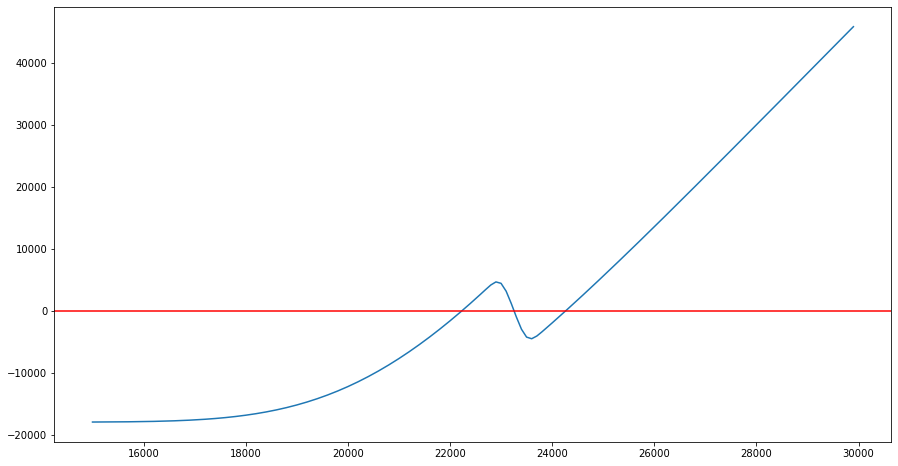

In [26]:
date = '2022-08-09 10:23:00'

struct = (w[0] * short_call1.plot(date, 0.175, vol=0.568) + w[1] * short_call2.plot(date, 0.175, vol=0.555) + w[2] * long_call.plot(date, 0.175, vol=0.714))[150:300]

plt = struct.plot(figsize=(15,8))
plt.axhline(0, color = 'red')